# 回帰問題

* データセットの探索と可視化
* 線形回帰モデルを実装するための各種アプローチ
* ハズレ値に対する強固な回帰モデルのトレーニング
* 回帰モデルの評価と一般的な問題の診断
* 回帰モデルの非線形データでの学習

## Housingデータセットの探索

1978年に収集されたボストン近郊の住宅情報で、506個のサンプルの特徴量が集計されている
UCI Machine Learning Repositoryから無料でダウンロード可能

* CRIM ... 犯罪発生率（人口単位）
* ZN ... 25,000平方フィート以上の住宅区画の割合
* INDUS ... 非小売業の土地面積の割合
* CHAS ... チャールズ側沿いかどうか（川沿いの場合1、そうでない場合0）
* NOX ... 窒素酸化物の濃度（pphm単位)
* RM ... 1戸あたりの平均部屋数
* AGE ... 1940年よりも前に建てられた家屋の割合
* DIS ... ボストンの主な5つの雇用圏までの重み付きの距離
* RAD ... 幹線道路へのアクセス指数
* TAX ... 10,000ドルあたりの所得税率
* PTRATIO ... 教師あたりの生徒の数（人口単位）
* B ... $1000(Bk - 0.63)^2$ として計算: Bkはアフリカ系アメリカ人住居者の割合（人口単位）
* LSTAT ... 低所得者の割合
* MEDV ... 住宅価格の中央値（単位: 1,000ドル)

MEDVの住宅価格の中央値をラベルyとして予測するモデルを作成する

In [5]:
# データの読み込み
import pandas as pd

DATA_URL = 'https://raw.githubusercontent.com/rasbt/python-machine-learning-book/master/code/datasets/housing/housing.data'
df = pd.read_csv(DATA_URL, header=None, sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


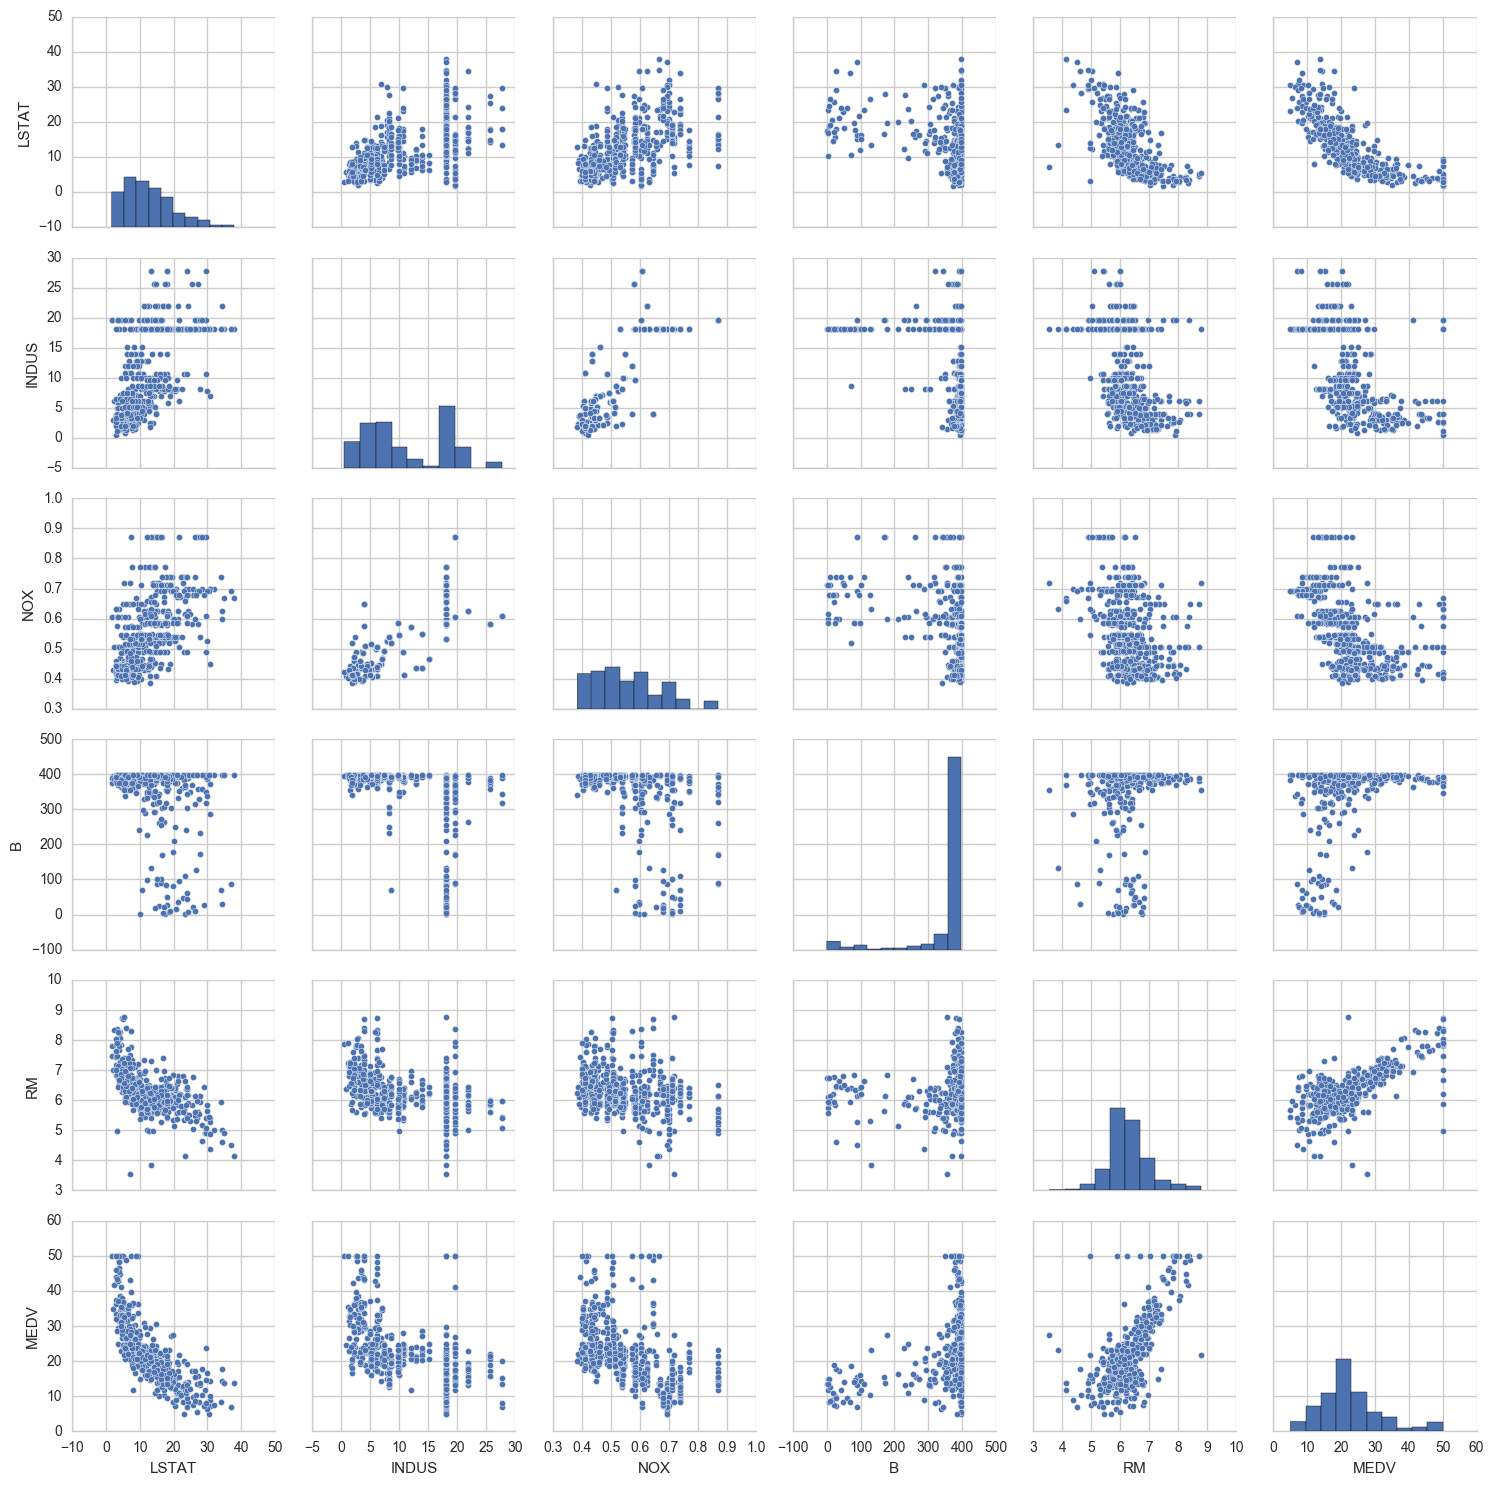

In [6]:
# 散布図行列を作成
# 外れ値、データの分布、特徴量の関係を視覚的に検出するのに役立つ
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# searbornのグラフのスタイル指定
sns.set(style='whitegrid', context='notebook')

# 変数のペアの関係をプロット
cols = ['LSTAT', 'INDUS', 'NOX', 'B', 'RM', 'MEDV']
sns.pairplot(df[cols], size=2.5) # sizeは1面のインチサイズ
plt.show()

# プロットしてよみとれることの例
# 4行目5列目の散布図: RM(1戸あたりの平均部屋数)とMEDV(住宅価格の中央値)の関係は線形
# 5行目5列目のヒストグラム: MEDVは正規分布に見えるものの、外れ値がいくつかある

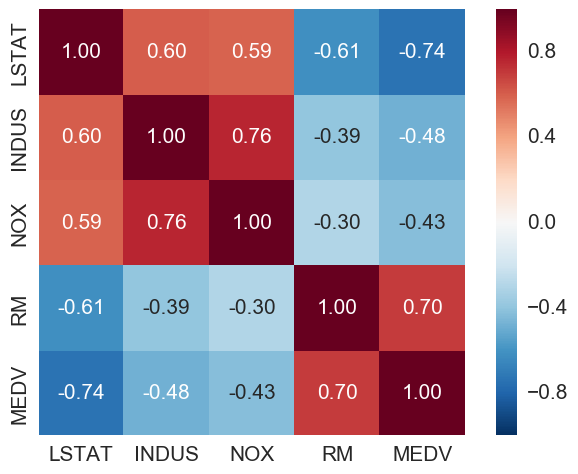

In [4]:
# 相関行列を作成する
# 特徴量の間の線形関係を数値化できる。
# ピアソンの積率相関係数を成分とする正方行列
import numpy as np

sns.set(font_scale=1.5) # フォントサイズを指定
cm = np.corrcoef(df[cols].values.T) # ピアソンの積率相関係数を計算
hm = sns.heatmap(cm,
                                 cbar=True,
                                 annot=True,
                                 square=True,
                                 fmt='.2f',
                                 annot_kws={'size': 15},
                                 yticklabels=cols,
                                 xticklabels=cols)

# plt.tight_layout()
# plt.savefig('./figures/corr_mat.png', dpi=300)
plt.show()

# 目的変数のMEDV(住宅価格の中央値)との相関が高い特徴量に注目する
# LSTAT(低所得者の割合)が-0.74で最も相関が高い。
# その次は、RM(1戸あたりの平均部屋数)が0.70で相関が高い。
# 上の散布図でそれぞれ相関関係があることは明らかだった。

## モデルの実装

RMとMEDVが相関が高いので、入力xをRM、ラベルyをMEDVとして単回帰モデルを作成する

In [5]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

In [7]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import  StandardScaler

# 入力X, 正解ラベルyを取得
X = df[['RM']].values
y = df['MEDV'].values

# 特徴スケーリングを行う
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y)

# 線形回帰モデルでトレーニング
liner_regression = LinearRegressionGD()
liner_regression.fit(X_std, y_std)

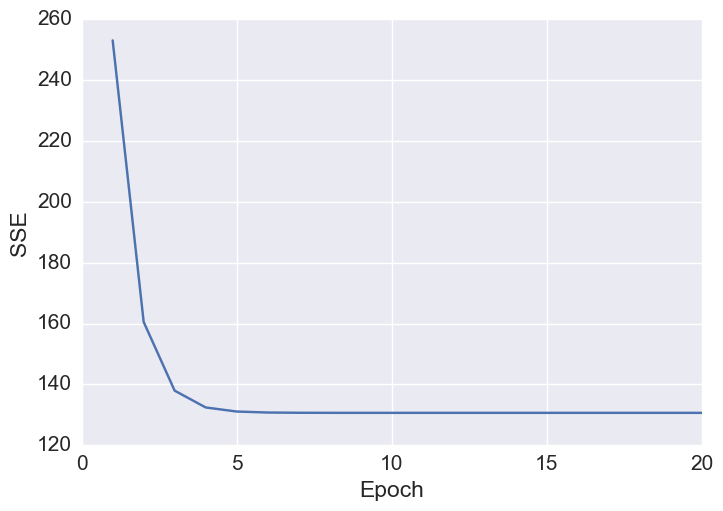

In [8]:
# 学習曲線をプロットする
plt.plot(range(1, liner_regression.n_iter+1), liner_regression.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

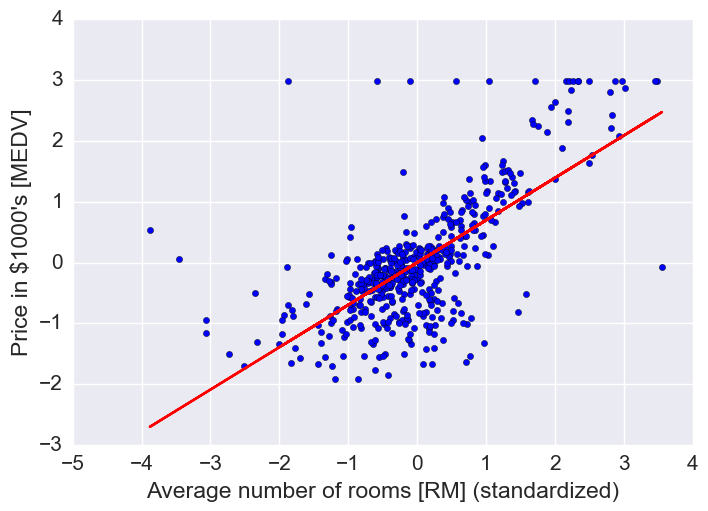

In [12]:
# トレーニングデータにどの程度適合しているかプロット
def liner_regression_plot(X, y, model):
    plt.scatter(X, y, c='blue')
    plt.plot(X, model.predict(X), color='red')
    
liner_regression_plot(X_std, y_std, liner_regression)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.show()